In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [4]:
print("\n".join(os.listdir("./")))
df = pd.read_csv('data/DJI_modified_sma.csv')

AIAlpha.ipynb
DJI_STO_20period_sma10.csv
.DS_Store
saved_model
preprocess
__pycache__
README.md
baseline.ipynb
utils.py
model_FE.ipynb
.ipynb_checkpoints
model_fe_too.ipynb
data
tmp


In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.013989,1290.079956,1290.079956,1290.079956,1290.079956,1290.079956


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
count,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8.762000e+03,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000
mean,9741.540516,9800.407342,9680.969127,9744.180560,9744.180560,1.387696e+08,9738.288319,9730.964669,9709.143362,9636.784488,9564.918578,9458.638821
std,6379.993445,6406.101221,6351.951044,6380.505213,6380.505213,1.218227e+08,6375.645973,6369.877839,6353.093276,6298.411546,6243.063416,6160.864855
min,1243.709961,1251.209961,1235.530029,1242.050049,1242.050049,2.530000e+06,1246.420020,1253.411023,1261.478818,1242.050049,1242.050049,1242.050049
25%,3614.900086,3635.000000,3595.430053,3616.775024,3616.775024,2.666250e+07,3616.110974,3611.814222,3598.590109,3561.849625,3522.914113,3460.122220
50%,9958.229981,10031.165040,9873.945312,9958.939942,9958.939942,1.047850e+08,9955.690039,9966.947461,10013.490235,10006.442710,9937.613086,9844.902081
75%,12604.689700,12672.895020,12536.984863,12608.264892,12608.264892,2.266075e+08,12590.240043,12576.958180,12560.957970,12505.968420,12464.211825,12284.940260
max,27364.689450,27398.679690,27294.169920,27359.160160,27359.160160,2.190810e+09,27293.928120,27255.588090,27026.882730,26657.372450,26448.710060,26196.764980


In [7]:
df = df.drop('Adj Close', axis=1)

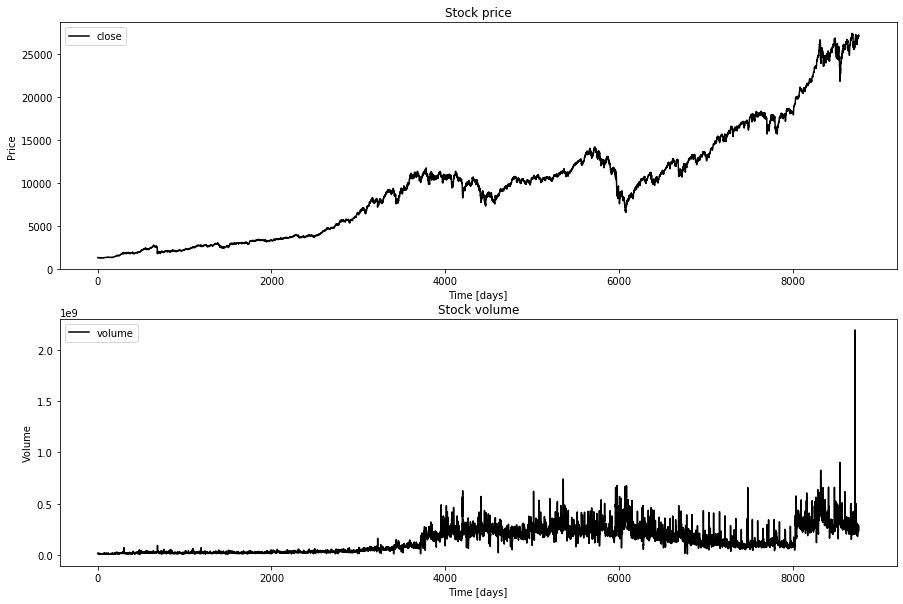

In [8]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], color='black', label='close')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [9]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))
    df['sma5'] = min_max_scaler.fit_transform(df['sma5'].to_numpy().reshape(-1, 1))
    df['sma10'] = min_max_scaler.fit_transform(df['sma10'].to_numpy().reshape(-1, 1))
    df['sma25'] = min_max_scaler.fit_transform(df['sma25'].to_numpy().reshape(-1, 1))
    df['sma75'] = min_max_scaler.fit_transform(df['sma75'].to_numpy().reshape(-1, 1))
    df['sma125'] = min_max_scaler.fit_transform(df['sma125'].to_numpy().reshape(-1, 1))
    df['sma200'] = min_max_scaler.fit_transform(df['sma200'].to_numpy().reshape(-1, 1))
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [10]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close', 'sma5', 'sma10', 'sma25', 'sma75', 'sma125', 'sma200']
x_train.shape =  (6994, 19, 10)
y_train.shape =  (6994, 10)
x_val.shape =  (874, 19, 10)
y_val.shape =  (874, 10)
x_test.shape =  (874, 19, 10)
y_test.shape =  (874, 10)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [11]:
print(y_train[0]);
print("\n")
print(x_train[0]); 

[0.00124689 0.00160513 0.00141143 0.00168701 0.00130162 0.00112502
 0.00095598 0.0017336  0.00174795 0.0017656 ]


[[0.00130202 0.00169347 0.00120344 0.00193628 0.00177368 0.00150791
  0.00120864 0.00198974 0.00200621 0.00202647]
 [0.00205429 0.002061   0.00166548 0.00175479 0.00159171 0.00132562
  0.00102468 0.00180324 0.00181817 0.00183652]
 [0.00151334 0.00161354 0.0014241  0.00171229 0.00154909 0.00128293
  0.0009816  0.00175957 0.00177413 0.00179204]
 [0.00127216 0.00133474 0.00131396 0.00136577 0.00120165 0.00093488
  0.00063035 0.00140348 0.0014151  0.00142939]
 [0.0010861  0.00167244 0.00128403 0.00183902 0.00155846 0.00141023
  0.00111006 0.0018898  0.00190545 0.00192468]
 [0.00192757 0.00190917 0.00165281 0.00165332 0.00150172 0.0012237
  0.00092182 0.00169897 0.00171304 0.00173033]
 [0.00157651 0.00165561 0.00151734 0.00147566 0.00144574 0.00104526
  0.00074174 0.0015164  0.00152896 0.00154439]
 [0.00158072 0.00175275 0.00169925 0.00183902 0.00147116 0.00141023
  0.00111006 

In [12]:
df_index.head(20)

,Open,High,Low,Close,sma5,sma10,sma25,sma75,sma125,sma200
0,0.001302,0.001693,0.001203,0.001936,0.001774,0.001508,0.001209,0.001990,0.002006,0.002026
1,0.002054,0.002061,0.001665,0.001755,0.001592,0.001326,0.001025,0.001803,0.001818,0.001837
2,0.001513,0.001614,0.001424,0.001712,0.001549,0.001283,0.000982,0.001760,0.001774,0.001792
3,0.001272,0.001335,0.001314,0.001366,0.001202,0.000935,0.000630,0.001403,0.001415,0.001429
4,0.001086,0.001672,0.001284,0.001839,0.001558,0.001410,0.001110,0.001890,0.001905,0.001925
5,0.001928,0.001909,0.001653,0.001653,0.001502,0.001224,0.000922,0.001699,0.001713,0.001730
6,0.001577,0.001656,0.001517,0.001476,0.001446,0.001045,0.000742,0.001516,0.001529,0.001544
7,0.001581,0.001753,0.001699,0.001839,0.001471,0.001410,0.001110,0.001890,0.001905,0.001925
8,0.001775,0.001757,0.001759,0.001835,0.001565,0.001406,0.001106,0.001885,0.001901,0.001920
9,0.001695,0.001550,0.001271,0.001302,0.001458,0.001242,0.000566,0.001338,0.001349,0.001363


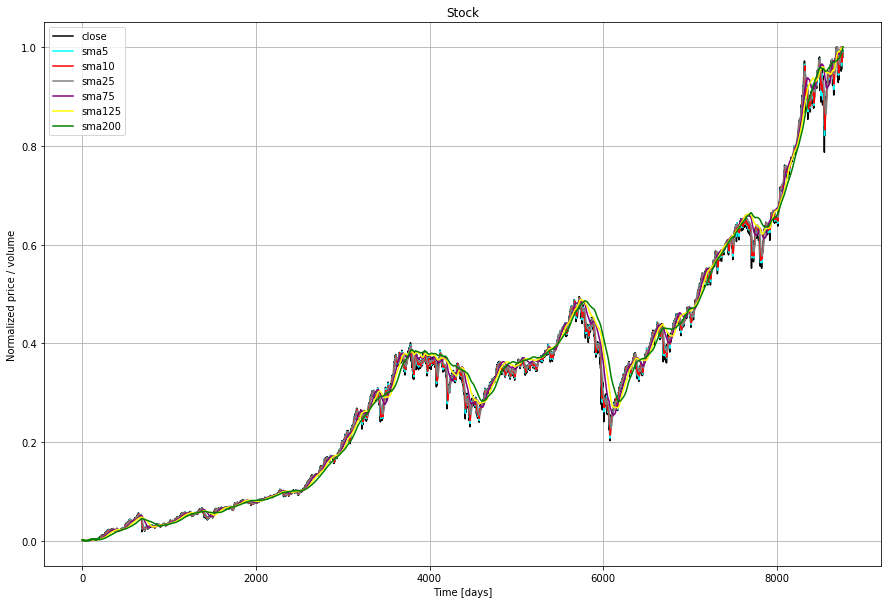

In [13]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_index_norm['Close'], color='black', label='close')
plt.plot(df_index_norm['sma5'], color='cyan', label='sma5')
plt.plot(df_index_norm['sma10'], color='red', label='sma10')
plt.plot(df_index_norm['sma25'], color='gray', label='sma25')
plt.plot(df_index_norm['sma75'], color='purple', label='sma75')
plt.plot(df_index_norm['sma125'], color='yellow', label='sma125')
plt.plot(df_index_norm['sma200'], color='green', label='sma200')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [60]:
from tensorflow.keras import backend as K
K.clear_session()

In [61]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten,LeakyReLU,Dropout

def get_bi_gru():
    
    input1 = Input(shape=(19,10,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = LSTM(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(10,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [92]:
model = get_bi_gru()
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 19, 10)]          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 19, 512)           546816    
_________________________________________________________________
time_distributed_8 (TimeDist (None, 19, 512)           0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               328192    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512 

In [93]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/model_sma_NoVOL.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, min_lr=0.0001)
]

#################
batch_size = 256
epochs = 300
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=2, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 6994 samples, validate on 874 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.08283, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 16s - loss: 0.7470 - mse: 0.7470 - val_loss: 0.0828 - val_mse: 0.0828
Epoch 2/300

Epoch 00002: val_loss improved from 0.08283 to 0.04740, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 10s - loss: 0.2133 - mse: 0.2133 - val_loss: 0.0474 - val_mse: 0.0474
Epoch 3/300

Epoch 00003: val_loss did not improve from 0.04740
6994/6994 - 10s - loss: 0.0714 - mse: 0.0714 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 4/300

Epoch 00004: val_loss did not improve from 0.04740
6994/6994 - 11s - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0678 - val_mse: 0.0678
Epoch 5/300

Epoch 00005: val_loss did not improve from 0.04740
6994/6994 - 12s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0931 - val_mse: 0.0931
Epoch 6/300

Epoch 00006: val_loss did not improve from 0.04740
6994/6994 - 12s - loss: 0.0036 - mse: 0.003

Epoch 49/300

Epoch 00049: val_loss improved from 0.00115 to 0.00024, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 11s - loss: 7.3527e-04 - mse: 7.3527e-04 - val_loss: 2.4321e-04 - val_mse: 2.4321e-04
Epoch 50/300

Epoch 00050: val_loss did not improve from 0.00024
6994/6994 - 11s - loss: 6.8123e-04 - mse: 6.8123e-04 - val_loss: 9.7162e-04 - val_mse: 9.7162e-04
Epoch 51/300

Epoch 00051: val_loss did not improve from 0.00024
6994/6994 - 11s - loss: 6.5231e-04 - mse: 6.5231e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 52/300

Epoch 00052: val_loss did not improve from 0.00024
6994/6994 - 11s - loss: 7.6144e-04 - mse: 7.6144e-04 - val_loss: 8.9972e-04 - val_mse: 8.9972e-04
Epoch 53/300

Epoch 00053: val_loss did not improve from 0.00024
6994/6994 - 11s - loss: 7.5601e-04 - mse: 7.5601e-04 - val_loss: 8.7048e-04 - val_mse: 8.7048e-04
Epoch 54/300

Epoch 00054: val_loss did not improve from 0.00024
6994/6994 - 11s - loss: 6.4050e-04 - mse: 6.4050e-04 - val_loss: 4.4751e-04 

Epoch 98/300

Epoch 00098: val_loss did not improve from 0.00010
6994/6994 - 11s - loss: 5.4929e-04 - mse: 5.4929e-04 - val_loss: 1.5197e-04 - val_mse: 1.5197e-04
Epoch 99/300

Epoch 00099: val_loss did not improve from 0.00010
6994/6994 - 12s - loss: 5.7816e-04 - mse: 5.7816e-04 - val_loss: 1.4693e-04 - val_mse: 1.4693e-04
Epoch 100/300

Epoch 00100: val_loss did not improve from 0.00010
6994/6994 - 12s - loss: 5.5591e-04 - mse: 5.5591e-04 - val_loss: 1.0617e-04 - val_mse: 1.0617e-04
Epoch 101/300

Epoch 00101: val_loss improved from 0.00010 to 0.00009, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 - 11s - loss: 6.7024e-04 - mse: 6.7024e-04 - val_loss: 9.3356e-05 - val_mse: 9.3356e-05
Epoch 102/300

Epoch 00102: val_loss did not improve from 0.00009
6994/6994 - 11s - loss: 5.8359e-04 - mse: 5.8359e-04 - val_loss: 1.3476e-04 - val_mse: 1.3476e-04
Epoch 103/300

Epoch 00103: val_loss did not improve from 0.00009
6994/6994 - 11s - loss: 6.6494e-04 - mse: 6.6494e-04 - val_loss:

Epoch 147/300

Epoch 00147: val_loss did not improve from 0.00008
6994/6994 - 10s - loss: 5.8629e-04 - mse: 5.8629e-04 - val_loss: 2.1929e-04 - val_mse: 2.1929e-04
Epoch 148/300

Epoch 00148: val_loss did not improve from 0.00008
6994/6994 - 11s - loss: 5.6964e-04 - mse: 5.6964e-04 - val_loss: 1.3391e-04 - val_mse: 1.3391e-04
Epoch 149/300

Epoch 00149: val_loss did not improve from 0.00008
6994/6994 - 11s - loss: 5.2889e-04 - mse: 5.2889e-04 - val_loss: 2.8445e-04 - val_mse: 2.8445e-04
Epoch 150/300

Epoch 00150: val_loss did not improve from 0.00008
6994/6994 - 11s - loss: 5.4023e-04 - mse: 5.4023e-04 - val_loss: 1.1152e-04 - val_mse: 1.1152e-04
Epoch 151/300

Epoch 00151: val_loss did not improve from 0.00008
6994/6994 - 10s - loss: 6.0147e-04 - mse: 6.0147e-04 - val_loss: 1.4040e-04 - val_mse: 1.4040e-04
Epoch 152/300

Epoch 00152: val_loss did not improve from 0.00008
6994/6994 - 11s - loss: 5.8900e-04 - mse: 5.8900e-04 - val_loss: 2.0116e-04 - val_mse: 2.0116e-04
Epoch 153/300

E

Epoch 197/300

Epoch 00197: val_loss did not improve from 0.00008
6994/6994 - 12s - loss: 5.3969e-04 - mse: 5.3969e-04 - val_loss: 1.3842e-04 - val_mse: 1.3842e-04
Epoch 198/300

Epoch 00198: val_loss did not improve from 0.00008
6994/6994 - 13s - loss: 5.3082e-04 - mse: 5.3082e-04 - val_loss: 2.2011e-04 - val_mse: 2.2011e-04
Epoch 199/300

Epoch 00199: val_loss did not improve from 0.00008
6994/6994 - 14s - loss: 5.6665e-04 - mse: 5.6665e-04 - val_loss: 1.6403e-04 - val_mse: 1.6403e-04
Epoch 200/300

Epoch 00200: val_loss did not improve from 0.00008
6994/6994 - 13s - loss: 5.1170e-04 - mse: 5.1170e-04 - val_loss: 2.8028e-04 - val_mse: 2.8028e-04
Epoch 201/300

Epoch 00201: val_loss did not improve from 0.00008
6994/6994 - 13s - loss: 5.2000e-04 - mse: 5.2000e-04 - val_loss: 3.4378e-04 - val_mse: 3.4378e-04
Epoch 202/300

Epoch 00202: val_loss did not improve from 0.00008
6994/6994 - 12s - loss: 5.2692e-04 - mse: 5.2692e-04 - val_loss: 2.1130e-04 - val_mse: 2.1130e-04
Epoch 203/300

E

Epoch 247/300

Epoch 00247: val_loss did not improve from 0.00008
6994/6994 - 13s - loss: 4.9088e-04 - mse: 4.9088e-04 - val_loss: 5.2230e-04 - val_mse: 5.2230e-04
Epoch 248/300

Epoch 00248: val_loss did not improve from 0.00008
6994/6994 - 13s - loss: 4.9905e-04 - mse: 4.9905e-04 - val_loss: 7.4220e-04 - val_mse: 7.4220e-04
Epoch 249/300

Epoch 00249: val_loss did not improve from 0.00008
6994/6994 - 13s - loss: 4.7759e-04 - mse: 4.7759e-04 - val_loss: 5.0003e-04 - val_mse: 5.0003e-04
Epoch 250/300

Epoch 00250: val_loss did not improve from 0.00008
6994/6994 - 14s - loss: 5.3960e-04 - mse: 5.3960e-04 - val_loss: 3.4917e-04 - val_mse: 3.4917e-04
Epoch 251/300

Epoch 00251: val_loss did not improve from 0.00008
6994/6994 - 14s - loss: 4.8985e-04 - mse: 4.8985e-04 - val_loss: 2.7108e-04 - val_mse: 2.7108e-04
Epoch 252/300

Epoch 00252: val_loss did not improve from 0.00008
6994/6994 - 14s - loss: 4.8394e-04 - mse: 4.8394e-04 - val_loss: 1.7683e-04 - val_mse: 1.7683e-04
Epoch 253/300

E

Epoch 298/300

Epoch 00298: val_loss did not improve from 0.00008
6994/6994 - 14s - loss: 4.3616e-04 - mse: 4.3616e-04 - val_loss: 2.0237e-04 - val_mse: 2.0237e-04
Epoch 299/300

Epoch 00299: val_loss did not improve from 0.00008
6994/6994 - 17s - loss: 4.6179e-04 - mse: 4.6179e-04 - val_loss: 1.8297e-04 - val_mse: 1.8297e-04
Epoch 300/300

Epoch 00300: val_loss did not improve from 0.00008
6994/6994 - 18s - loss: 4.6720e-04 - mse: 4.6720e-04 - val_loss: 3.7475e-04 - val_mse: 3.7475e-04


In [94]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


Text(0, 0.5, 'loss')

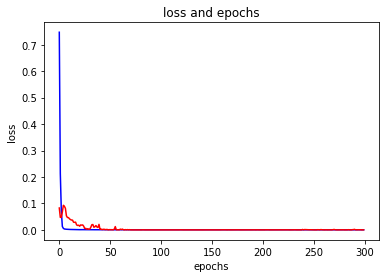

In [114]:
plt.title("loss and epochs")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")


In [107]:
#Load the minimum loss weight 
model = get_bi_gru()
model.load_weights("./saved_model/model_sma_NoVOL.h5")

In [ ]:
# Load saved model 
#from tensorflow.keras.models import load_model
#model = load_model("path")

In [108]:
x_train.shape
y_train.shape

(6994, 10)

In [109]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [110]:
print(y_test_pred[0])

[0.64490217 0.6339851  0.62784296 0.6286993  0.6275717  0.62815064
 0.6211791  0.6440784  0.6365863  0.6485162 ]


In [111]:
print( y_test_pred[:, 1][0])

0.6339851


In [112]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3, 'sma5':4, 'sma10':5, 'sma25':6, 'sma75':7, 'sma125':8, 'sma200':9}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



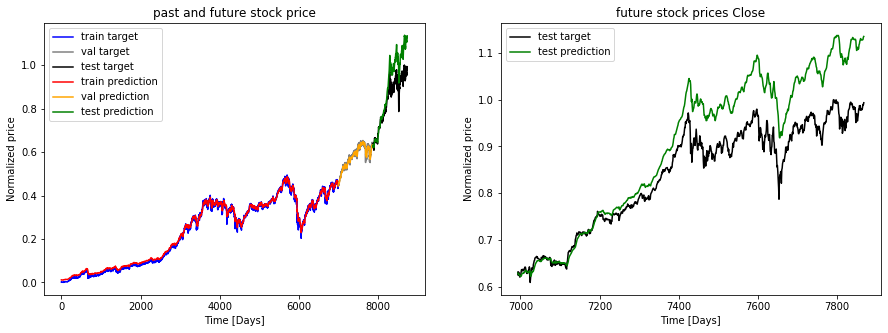

In [113]:
plot_compare('Close')

In [106]:
#model.save("saved_model/best_one.h")